In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

!pip install hmmlearn
from hmmlearn import hmm
from torch.distributions import uniform

import sys
sys.path.append("../")

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import os
import argparse
import pickle
import timeit

from torch._utils import _accumulate
import torch.utils.data as data_utils
from torch.utils.data import Subset
import torch.nn.utils.clip_grad as clip_grad
import torch.optim.lr_scheduler as lr_scheduler

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
import datetime as dt
import time
import random

import copy

     |████████████████████████████████| 129 kB 5.3 MB/s 


In [2]:
#Generate Datasets using HMM

def random_transmat(n_states):
    matrix = np.random.rand(n_states, n_states)
    return matrix/matrix.sum(axis=1)[:,None]

def random_startprob(n_states):
    startprob = np.random.rand(n_states)
    return startprob/startprob.sum()

def random_means(n_features):
    return np.random.randint(5, size=(n_features,n_features))

def generate_hmm(n_states, n_features , length):
    #GENERATING A MODEL
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")
    model.startprob_ = random_startprob(n_states)
    model.transmat_ = random_transmat(n_states)

    model.means_ = random_means(n_features)
    model.covars_ = np.tile(np.identity(n_features), (n_features, 1, 1))


    #SAMPLING FROM MODEL and STORING IN TENSOR

    #Number of Samples in Dataset
    dataset=[]
    states = []

    
    X, Z = model.sample(length)
    dataset.append(np.array(X))
    states.append(Z)

    dataset = np.stack(dataset)
    
    return np.array(X), np.array(Z)

def sliding_windows(dataset, Z, window_length = 10):
    lis = []
    targets=[]

    window_length = 10
    if len(dataset) >= window_length+1:
        for i in range(0, len(dataset)-window_length, 1):

            x_window = dataset[i:i+window_length, :]
            z_window = Z[i:i+window_length]

            lis.append(x_window)
            targets.append(z_window[-1])
    return np.array(lis), np.array(targets)

def generate_time_dependent_flip(length, startprob, transmat):
    #GENERATING A MODEL


    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full")
    model.startprob_ = startprob
    model.transmat_ = transmat

    #this doesn't actually matter for us
    model.means_ = np.array([[0.0, 0.0], 
                             [5.0, 10.0]])
    model.covars_ = np.tile(np.identity(2), (3, 1, 1))


    #SAMPLING FROM MODEL and STORING IN TENSOR

    #Number of Samples in Dataset


    X, Z = model.sample(length)

    
    return Z

In [3]:
#Injecting Noise into Labels

#Given a flip_mask, flip an input
def flip(array, flip_mask):
    flipped_array = np.logical_xor(array, flip_mask, out=array)
    return flipped_array

#Class Independent / Time Independent
def flip_labels_basic(array, flip_probability):
    flip_mask = np.random.binomial(1, 0.5, len(array))
    return flip(array, flip_mask)

#Class Dependent / Time Independent
def flip_labels_class(array, flip_probability_0, flip_probability_1):
    flip_mask = []
    for elem in array:
        if elem == 0:
            to_flip = np.random.binomial(1, flip_probability_0, 1)[0]
            flip_mask.append(to_flip)
        else:
            to_flip = np.random.binomial(1, flip_probability_1, 1)[0]
            flip_mask.append(to_flip)
            
    return flip(array, flip_mask)

#Class Independent / Time Dependent
def flip_labels_time(array, startprob, transmat):
    flip_mask = generate_time_dependent_flip(len(array), startprob, transmat)[0]

    return flip(array, flip_mask)


#Class Dependent / Time Dependent
#This can be achieved by careful design of the transition matrix (transmat)

In [4]:
dataset,Z = generate_hmm(2,3,100)

In [5]:
Z.shape

(100,)

In [6]:
startprob = random_startprob(2)
transmat = np.array([[0.95, 0.05],
                    [0.95, 0.05]])

In [7]:
def generate_dataset(n_states, n_features, length,window_length, train_ratio, method, 
                     flip_probability= None, flip_probability_0=None, flip_probability_1=None,
                    startprob=None, transmat=None):
    
    #Generate Data
    dataset, states_true = generate_hmm(n_states, n_features , length)
    
    if method == "basic":
        states_flipped = (flip_labels_basic(states_true, flip_probability))
        
    elif method == "class":
        states_flipped = (flip_labels_class(states_true, flip_probability_0, flip_probability_1))
        
    elif method == "time":
        states_flipped = (flip_labels_time(states_true, startprob, transmat))
    
    #RESHAPE INTO WINDOWS
    dataset_windows, states_true = sliding_windows(dataset, states_true, window_length= window_length)
    
    #RESHAPE INTO WINDOWS
    _, states_flipped = sliding_windows(dataset, states_flipped, window_length= window_length)
    
    x_train = dataset_windows[:int(train_ratio*len(dataset_windows)),:,:]
    x_test = dataset_windows[int(train_ratio*len(dataset_windows)):,:,:]
    
   
    #Flip The Labels according to method
    
    
    y_train_true = states_true[:int(train_ratio*len(dataset_windows))]
    y_test_true = states_true[int(train_ratio*len(dataset_windows)):]
    
    y_train_flipped = np.array(states_flipped[:int(train_ratio*len(dataset_windows))])
    y_test_flipped = np.array(states_flipped[int(train_ratio*len(dataset_windows)):])
    
    
    return x_train, y_train_true, y_train_flipped, x_test, y_test_true, y_test_flipped

In [8]:
def get_device():
    """Get a gpu if available."""
    if torch.cuda.device_count()>0:
        device = torch.device('cuda')
        print("Connected to a GPU")
    else:
        print("Using the CPU")
        device = torch.device('cpu')
    return device

def which_device(model):
    return next(model.parameters()).device


def add_channels(X):
    if len(X.shape) == 2:
        return X.reshape(X.shape[0], 1, X.shape[1],1)

    elif len(X.shape) == 3:
        return X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

    else:
        return "dimenional error"
    
def exp_lr_scheduler(epoch, optimizer, strategy='normal', decay_eff=0.1, decayEpoch=[]):
    """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""

    if strategy=='normal':
        if epoch in decayEpoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= decay_eff
            print('New learning rate is: ', param_group['lr'])
    else:
        print('wrong strategy')
        raise ValueError('A very specific bad thing happened.')

    return optimizer

    
    
def gaussian_init_(n_units, std=1):    
    sampler = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([std/n_units]))
    A_init = sampler.sample((n_units, n_units))[..., 0]  
    return A_init

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, feature_size, n_state, hidden_size=128, rnn="GRU", regres=True, bidirectional=False, return_all=False,
                 seed=random.seed('2021')):
        
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_state = n_state
        self.seed = seed
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.rnn_type = rnn
        self.regres = regres
        self.return_all = return_all
        
        # Input to torch LSTM should be of size (seq_len, batch, input_size)
        if self.rnn_type == 'GRU':
            self.rnn = nn.GRU(feature_size, self.hidden_size, bidirectional=bidirectional, batch_first=True).to(self.device)
        else:
            self.rnn = nn.LSTM(feature_size, self.hidden_size, bidirectional=bidirectional, batch_first=True).to(self.device)

        self.regressor = nn.Sequential(nn.BatchNorm1d(num_features=self.hidden_size),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(self.hidden_size, self.n_state),
                                       nn.Softmax(-1))

    def forward(self, input, past_state=None, **kwargs):
        input = input.to(self.device)
        self.rnn.to(self.device)
        self.regressor.to(self.device)
        if not past_state:
            #  hidden states: (num_layers * num_directions, batch, hidden_size)
            past_state = torch.zeros([1, input.shape[0], self.hidden_size]).to(self.device)
        if self.rnn_type == 'GRU':
            all_encodings, encoding = self.rnn(input, past_state)
        else:
            all_encodings, (encoding, state) = self.rnn(input, (past_state, past_state))
        
        if self.regres:
            if not self.return_all:
                return self.regressor(encoding.view(encoding.shape[1], -1))
            else:
                reshaped_encodings = all_encodings.view(all_encodings.shape[1]*all_encodings.shape[0],-1)
                return torch.t(self.regressor(reshaped_encodings).view(all_encodings.shape[0],-1))
        else:
            return encoding.view(encoding.shape[1], -1)
        
        
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(dt.timedelta(seconds=elapsed_rounded))
            
def save_ckpt(generator_model, output_dir, data):
    check_pt_dir = os.path.join(output_dir,data,'ckpt')
    fname = os.path.join(check_pt_dir,'generator.pt')
    os.makedirs(check_pt_dir, exist_ok=True)
    torch.save(generator_model.state_dict(), fname)
    
def get_accuracy(model, loader):
    
    correct, total = 0, 0
    for xs, ts in loader:
        xs.to(device)
        ts.to(device)
        zs = model(xs)
        
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        ts = torch.argmax(ts, 1)

        correct += pred.eq(ts.view_as(pred)).sum().item()
        total += int(ts.shape[0])
    return correct / total

In [10]:
import copy


def train_model(model, train_dataloader, n_epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss().to(device)

    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    iters,iters_sub, train_acc, val_acc = [], [] ,[], []
    
    best_loss = 10000.0
    
    n=0
    for epoch in range(1, n_epochs + 1):
        t0 = time.time()
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch, n_epochs))
        print('Training...')

        total_train_loss = 0
        train_losses=[]
        model = model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = (time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input= batch[0].to(device)
            b_target =  batch[1].to(device)
            iters.append(n)
            optimizer.zero_grad()
            out = model(b_input)

            target = torch.argmax(b_target, 1)

            loss = criterion(out, target)

            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            train_losses.append(loss.item())
            
            if n % 10 == 0:
                iters_sub.append(n)
                
                #train_acc.append(get_accuracy(model, train_dataloader))
                #print(get_accuracy(model, train_dataloader))
                #val_acc.append(get_accuracy(model, validation_dataloader))
            # increment the iteration number
            n += 1

        training_time = (time.time() - t0)
        avg_train_loss = total_train_loss / len(train_dataloader)
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))


        print("")
        print("Running Validation...")

        t0 = time.time()
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        val_losses = []
        model = model.eval()

        train_loss = np.mean(train_losses)
    
        history['train'].append(train_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} ')
    plt.style.use('seaborn-white')
    plt.plot(history['train'])

    plt.title('LSTM  Training Curves')
    plt.ylabel('CE Loss')
    plt.xlabel('Epoch Number')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
    return model.eval(), history

def evaluate_model(model, x_test, y_test):
    #INFERENCE ON TEST SET
    predictions = model(x_test).max(1, keepdim=True)[1]
    
    y_test = y_test.numpy()
    y_pred = predictions.cpu().numpy()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    #print(accuracy)
    #print(f1)
    #print(precision)
    return accuracy

def lstm_driver(seed, x_test, y_test, x_train, y_train):
  train = data_utils.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train.reshape(-1, 1)))
  train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

  x_test = torch.flip(torch.tensor(x_test, dtype=torch.float), [1,2])
  y_test = torch.tensor(y_test_true, dtype=torch.int)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model = LSTMClassifier(3, #num features 
                  2, #num classes,
                  seed = seed,
                  rnn="GRU" #rnn type    
            )

  model, history = train_model(model, train_loader, 128, 5e-4)
  acc = evaluate_model(model, x_test, y_test)
  return acc

In [11]:
class NoisyRNN(nn.Module):
    def __init__(self, input_dim, output_classes, n_units=128, eps=0.01, 
                 beta=0.8, gamma_A=0.01, gamma_W=0.01, init_std=1, alpha=1,
                 solver='base', add_noise=0, mult_noise=0):
        super(NoisyRNN, self).__init__()

        self.device = get_device()


        self.n_units = n_units
        self.eps = eps
        self.solver = solver
        self.beta = beta
        self.alpha = alpha
        self.gamma_A = gamma_A
        self.gamma_W = gamma_W
        self.add_noise = add_noise
        self.mult_noise = mult_noise
        
        self.tanh = nn.Tanh()

        self.E = nn.Linear(input_dim, n_units)
        self.D = nn.Linear(n_units, output_classes)     
                                            
        self.C = nn.Parameter(gaussian_init_(n_units, std=init_std))            
        self.B = nn.Parameter(gaussian_init_(n_units, std=init_std))    
        self.I = torch.eye(n_units).to(self.device)   

        self.d = nn.Parameter(torch.rand(self.n_units).float().to(self.device)*0 + eps)           


    def forward(self, x, mode='test'):
        T = x.shape[1]
        h = torch.zeros(x.shape[0], self.n_units).to(which_device(self))

        for i in range(T):
            z = self.E(x[:,i,:])

            if i == 0:
                    A = self.beta * (self.B - self.B.transpose(1, 0)) + (1-self.beta) * (self.B + self.B.transpose(1, 0)) - self.gamma_A * self.I
                    W = self.beta * (self.C - self.C.transpose(1, 0)) + (1-self.beta) * (self.C + self.C.transpose(1, 0)) - self.gamma_W * self.I
                
                        
            add_noise = 0.0
            mult_noise = 1.0
            if mode == 'train':
                if self.add_noise > 0:
                    add_noise = self.add_noise * torch.randn(h.shape[0], h.shape[1]).float().to(self.device)
                            
                if self.mult_noise > 0:
                    #mult_noise = self.mult_noise * torch.randn(h.shape[0], h.shape[1]).float().to(self.device) + 1
                    mult_noise = self.mult_noise * torch.rand(h.shape[0], h.shape[1]).float().to(self.device) + (1-self.mult_noise)
                        

            if self.solver == 'base': 
                h_update = self.alpha * torch.matmul(h, A) + self.tanh(torch.matmul(h, W) + z)                
                h = h + self.eps * h_update
            elif self.solver == 'noisy':
                h_update = self.alpha * torch.matmul(h, A) + self.tanh(torch.matmul(h, W) + z)                
                h = h + self.d * mult_noise * h_update + add_noise                              
                 
                
        # Decoder 
        #----------
        out = self.D(h)
        return out

In [12]:
#code for the driver

parser = argparse.ArgumentParser(description='Human Activity Data')
#
parser.add_argument('-f')
#
parser.add_argument('--name', type=str, default='mnist', metavar='N', help='dataset')
#
parser.add_argument('--batch-size', type=int, default=128, metavar='N', help='input batch size for training (default: 128)')
#
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N', help='input batch size for testing (default: 1000)')
#
parser.add_argument('--epochs', type=int, default=100, metavar='N', help='number of epochs to train (default: 90)')
#
parser.add_argument('--lr', type=float, default=0.0005, metavar='LR', help='learning rate (default: 0.1)')
#
parser.add_argument('--lr_decay', type=float, default=0.1, help='learning rate decay value (default: 0.1)')
#
parser.add_argument('--lr_decay_epoch', type=int, nargs='+', default=[30], help='decrease learning rate at these epochs.')
#
parser.add_argument('--wd', default=0.0, type=float, metavar='W', help='weight decay (default: 0.0)')
#
parser.add_argument('--gamma_W', default=0.001, type=float, metavar='W', help='diffiusion rate for W')
#
parser.add_argument('--gamma_A', default=0.001, type=float, metavar='W', help='diffiusion rate for A')
#
parser.add_argument('--beta', default=0.75, type=float, metavar='W', help='skew level')
#
parser.add_argument('--model', type=str, default='NoisyRNN', metavar='N', help='model name')
#
parser.add_argument('--solver', type=str, default='noisy', metavar='N', help='model name')
#
parser.add_argument('--n_units', type=int, default=64, metavar='S', help='number of hidden units')
#
parser.add_argument('--eps', default=0.1, type=float, metavar='W', help='time step for euler scheme')
#
parser.add_argument('--T', default=49, type=int, metavar='W', help='time steps')
#
parser.add_argument('--init_std', type=float, default=0.1, metavar='S', help='control of std for initilization')
#
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 0)')
#
parser.add_argument('--gclip', type=int, default=0, metavar='S', help='gradient clipping')
#
parser.add_argument('--optimizer', type=str, default='Adam', metavar='N', help='optimizer')
#
parser.add_argument('--alpha', type=float, default=1, metavar='S', help='for ablation study')
#
parser.add_argument('--add_noise', type=float, default=0.0, metavar='S', help='level of additive noise')
#
parser.add_argument('--mult_noise', type=float, default=0.0, metavar='S', help='level of multiplicative noise')
#
args = parser.parse_args()

if not os.path.isdir(args.name + '_results'):
    os.mkdir(args.name + '_results')

#==============================================================================
# set random seed to reproduce the work
#==============================================================================
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

#==============================================================================
# get device
#==============================================================================
device = get_device()

#==============================================================================
# get dataset
#==============================================================================

def driver(seed, train, test, nrnn = False):
  
  model = NoisyRNN(input_dim=int(3), output_classes=2, n_units=args.n_units, 
                eps=args.eps, beta=args.beta, gamma_A=args.gamma_A, gamma_W=args.gamma_W,
                init_std=args.init_std, alpha=args.alpha,  solver=args.solver, 
                add_noise=args.add_noise, mult_noise=args.mult_noise).to(device)

  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)        
  noise = torch.randn(1,693,10,3).float()


  #==============================================================================
  # set random seed to reproduce the work
  #==============================================================================
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)


  #==============================================================================
  # Model summary
  #==============================================================================
  print(model)    
  print('**** Setup ****')
  print('Total params: %.2fk' % (sum(p.numel() for p in model.parameters())/1000.0))
  print('************')    
    

  if args.optimizer == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.wd)
  elif  args.optimizer == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
  else:
      print("Unexpected optimizer!")
      raise 


  loss_func = nn.CrossEntropyLoss().to(device)

  # training and testing
  count = 0
  loss_hist = []
  test_acc = []

  t0 = timeit.default_timer()
  for epoch in range(args.epochs):
      model.train()
      lossaccum = 0
      
      for step, (x, y) in enumerate(train):
          count += 1
          
          # Reshape data for recurrent unit
          inputs = Variable(x.view(-1, 10, int(3))).to(device) # reshape x to (batch, time_step, input_size)         
          targets = Variable(y).to(device)

                  
          # send data to recurrent unit    
          output = model(inputs, mode='train')
          loss = loss_func(output, targets.long())
          
          
          optimizer.zero_grad()
          loss.backward()          
          
          if args.gclip != 0.0:
              torch.nn.utils.clip_grad_norm_(model.parameters(), args.gclip) # gradient clip
              
          optimizer.step() # update weights
          lossaccum += loss.item()

          if args.model == 'test':
              D = model.W.weight.data.cpu().numpy()  
              u, s, v = np.linalg.svd(D, 0)
              model.W.weight.data = torch.from_numpy(u.dot(v)).float().cuda()

      loss_hist.append(lossaccum)    
      
      if epoch % 1 == 0:
          model.eval()
          correct = 0
          total_num = 0
          for data, target in test: 
              data, target = data.to(device), target.to(device)               
              output = model(data.view(-1, 10, int(3)))                  
              
              pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
              #print(output.shape)
              #print(pred.shape)
              correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
              total_num += len(data)
          
          accuracy = correct / total_num
          test_acc.append(accuracy)
          print('Epoch: ', epoch, 'Iteration: ', count, '| train loss: %.4f' % loss.item(), '| test accuracy: %.3f' % accuracy)


      if nrnn == True:
          B = model.B.data.cpu().numpy()            
          A = args.alpha * (args.beta * (B - B.T) + (1-args.beta) * (B + B.T) - args.gamma_A * np.eye(args.n_units))
          A = 0.5 * (A + A.T)
          e, _ = np.linalg.eig(A)
          # print('Eigenvalues of A (min and max): ', (np.min(np.abs(e)), np.max(np.abs(e))))
          
          C = model.C.data.cpu().numpy()            
          W = args.beta * (C - C.T) + (1-args.beta) * (C + C.T) - args.gamma_W * np.eye(args.n_units)
          e, _ = np.linalg.eig(W)
          # print('Eigenvalues of A (min and max): ', (np.min(np.abs(e)), np.max(np.abs(e))))
              
              

      # schedule learning rate decay    
      optimizer=exp_lr_scheduler(epoch, optimizer, decay_eff=args.lr_decay, decayEpoch=args.lr_decay_epoch)

  print('total time: ', timeit.default_timer()  - t0 )


  torch.save(model, args.name + '_results/' + args.model + '_' + args.name + '_T_' + str(args.T) 
              + '_units_' + str(args.n_units) + '_beta_' + str(args.beta) 
              + '_gamma_A_' + str(args.gamma_A) + '_gamma_W_' + str(args.gamma_W) + '_eps_' + str(args.eps) 
              + '_solver_' + str(args.solver) + '_gclip_' + str(args.gclip) + '_optimizer_' + str(args.optimizer)
              + '_addnoise_' + str(args.add_noise) + '_multnoise_' + str(args.mult_noise) 
              + '_seed_' + str(args.seed) + '.pkl')  

  data = {'loss': lossaccum, 'testacc': test_acc}
  f = open(args.name + '_results/' + args.model + '_' + args.name + '_T_' + str(args.T) 
              + '_units_' + str(args.n_units) + '_beta_' + str(args.beta) 
              + '_gamma_A_' + str(args.gamma_A) + '_gamma_W_' + str(args.gamma_W) + '_eps_' + str(args.eps) 
              + '_solver_' + str(args.solver) + '_gclip_' + str(args.gclip) + '_optimizer_' + str(args.optimizer)
              + '_addnoise_' + str(args.add_noise) + '_multnoise_' + str(args.mult_noise) 
              + '_seed_' + str(args.seed) + '_loss.pkl',"wb")

  pickle.dump(data,f)
  f.close()

  return max(test_acc)

Connected to a GPU


In [13]:
seeds = [1, 2, 3]

Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.5770 | test accuracy: 0.576
Epoch:  1 Iteration:  140 | train loss: 0.6423 | test accuracy: 0.576
Epoch:  2 Iteration:  210 | train loss: 0.6057 | test accuracy: 0.576
Epoch:  3 Iteration:  280 | train loss: 0.5710 | test accuracy: 0.576
Epoch:  4 Iteration:  350 | train loss: 0.6293 | test accuracy: 0.609
Epoch:  5 Iteration:  420 | train loss: 0.5302 | test accuracy: 0.576
Epoch:  6 Iteration:  490 | train loss: 0.5847 | test accuracy: 0.599
Epoch:  7 Iteration:  560 | train loss: 0.4059 | test accuracy: 0.572
Epoch:  8 Iteration:  630 | train loss: 0.3694 | test accuracy: 0.606
Epoch:  9 Iteration:  700 | train loss: 0.5426 | test accuracy: 0.623
Epoch:  10 Iteration:  770 | train loss: 0.7419 | test accuracy: 0.636
Epoch:  11 Iteratio

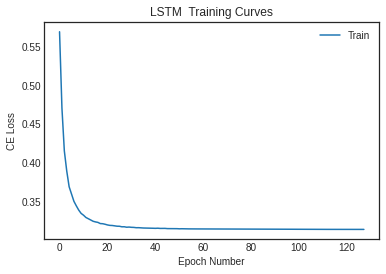

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.3592 | test accuracy: 0.576
Epoch:  1 Iteration:  140 | train loss: 0.3847 | test accuracy: 0.576
Epoch:  2 Iteration:  210 | train loss: 0.4792 | test accuracy: 0.576
Epoch:  3 Iteration:  280 | train loss: 0.6734 | test accuracy: 0.572
Epoch:  4 Iteration:  350 | train loss: 0.9147 | test accuracy: 0.572
Epoch:  5 Iteration:  420 | train loss: 0.8004 | test accuracy: 0.576
Epoch:  6 Iteration:  490 | train loss: 0.5548 | test accuracy: 0.576
Epoch:  7 Iteration:  560 | train loss: 0.5023 | test accuracy: 0.667
Epoch:  8 Iteration:  630 | train loss: 0.4963 | test accuracy: 0.623
Epoch:  9 Iteration:  700 | train loss: 0.6928 | test accuracy: 0.680
Epoch:  10 Iteration:  770 | train loss: 0.3168 | test accuracy: 0.616
Epoch:  11 Iteratio

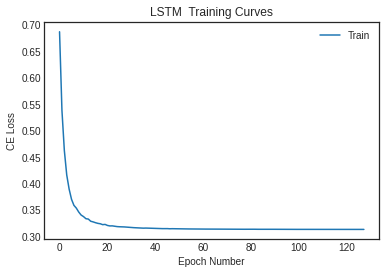

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 1.0390 | test accuracy: 0.576
Epoch:  1 Iteration:  140 | train loss: 0.6515 | test accuracy: 0.576
Epoch:  2 Iteration:  210 | train loss: 0.4559 | test accuracy: 0.576
Epoch:  3 Iteration:  280 | train loss: 0.6012 | test accuracy: 0.576
Epoch:  4 Iteration:  350 | train loss: 0.4092 | test accuracy: 0.576
Epoch:  5 Iteration:  420 | train loss: 0.4764 | test accuracy: 0.586
Epoch:  6 Iteration:  490 | train loss: 0.4046 | test accuracy: 0.576
Epoch:  7 Iteration:  560 | train loss: 0.5126 | test accuracy: 0.572
Epoch:  8 Iteration:  630 | train loss: 0.6285 | test accuracy: 0.697
Epoch:  9 Iteration:  700 | train loss: 0.3265 | test accuracy: 0.576
Epoch:  10 Iteration:  770 | train loss: 0.5680 | test accuracy: 0.586
Epoch:  11 Iteratio

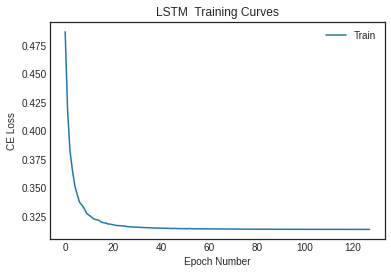

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
n_states = 2
n_features = 3
length = 1000
window_length = 10
train_ratio = 0.7
method = "No noise"
flip_probability_0 = 0.1
flip_probability_1 = 0.2
rnn_arr1 = []
nrnn_arr1 = []
lstm_arr1 = []
seed_arr1 = []
method_arr1 = []
specify_arr1 = []

x_train, y_train_true, y_train_flipped, x_test, y_test_true, y_test_flipped = generate_dataset(n_states, n_features, length,window_length, train_ratio, method = "class", 
                     flip_probability= None, flip_probability_0=flip_probability_0, flip_probability_1 = flip_probability_1, startprob=None, transmat=None)

train = data_utils.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train_true))
train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True)

test = data_utils.TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test_true))
test_loader = data_utils.DataLoader(test, batch_size=25, shuffle=True)

for seed in seeds:
  acc = driver(seed, train_loader, test_loader)
  acc2 = driver(seed, train_loader, test_loader, nrnn = True)
  acc3 = lstm_driver(seed, x_test, y_test_true, x_train, y_train_true)
  rnn_arr1.append(acc)
  nrnn_arr1.append(acc2)
  lstm_arr1.append(acc3)
  seed_arr1.append(seed)
  method_arr1.append(method)
  specify_arr1.append(None)

Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6442 | test accuracy: 0.438
Epoch:  1 Iteration:  140 | train loss: 0.7346 | test accuracy: 0.525
Epoch:  2 Iteration:  210 | train loss: 0.7122 | test accuracy: 0.455
Epoch:  3 Iteration:  280 | train loss: 0.6686 | test accuracy: 0.508
Epoch:  4 Iteration:  350 | train loss: 0.6388 | test accuracy: 0.434
Epoch:  5 Iteration:  420 | train loss: 0.7357 | test accuracy: 0.505
Epoch:  6 Iteration:  490 | train loss: 0.8165 | test accuracy: 0.431
Epoch:  7 Iteration:  560 | train loss: 0.6875 | test accuracy: 0.468
Epoch:  8 Iteration:  630 | train loss: 0.7507 | test accuracy: 0.545
Epoch:  9 Iteration:  700 | train loss: 0.7217 | test accuracy: 0.492
Epoch:  10 Iteration:  770 | train loss: 0.6202 | test accuracy: 0.522
Epoch:  11 Iteratio

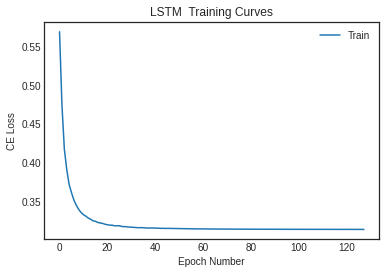

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.7246 | test accuracy: 0.455
Epoch:  1 Iteration:  140 | train loss: 0.7023 | test accuracy: 0.465
Epoch:  2 Iteration:  210 | train loss: 0.6682 | test accuracy: 0.438
Epoch:  3 Iteration:  280 | train loss: 0.6974 | test accuracy: 0.492
Epoch:  4 Iteration:  350 | train loss: 0.6467 | test accuracy: 0.461
Epoch:  5 Iteration:  420 | train loss: 0.6427 | test accuracy: 0.441
Epoch:  6 Iteration:  490 | train loss: 0.6741 | test accuracy: 0.552
Epoch:  7 Iteration:  560 | train loss: 0.6812 | test accuracy: 0.471
Epoch:  8 Iteration:  630 | train loss: 0.6169 | test accuracy: 0.519
Epoch:  9 Iteration:  700 | train loss: 0.6288 | test accuracy: 0.444
Epoch:  10 Iteration:  770 | train loss: 0.6891 | test accuracy: 0.481
Epoch:  11 Iteratio

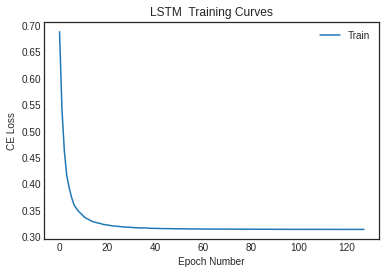

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.7469 | test accuracy: 0.539
Epoch:  1 Iteration:  140 | train loss: 0.6692 | test accuracy: 0.522
Epoch:  2 Iteration:  210 | train loss: 0.6236 | test accuracy: 0.525
Epoch:  3 Iteration:  280 | train loss: 0.6653 | test accuracy: 0.481
Epoch:  4 Iteration:  350 | train loss: 0.7035 | test accuracy: 0.488
Epoch:  5 Iteration:  420 | train loss: 0.6902 | test accuracy: 0.525
Epoch:  6 Iteration:  490 | train loss: 0.5876 | test accuracy: 0.441
Epoch:  7 Iteration:  560 | train loss: 0.5480 | test accuracy: 0.438
Epoch:  8 Iteration:  630 | train loss: 0.7642 | test accuracy: 0.434
Epoch:  9 Iteration:  700 | train loss: 0.6830 | test accuracy: 0.461
Epoch:  10 Iteration:  770 | train loss: 0.6899 | test accuracy: 0.481
Epoch:  11 Iteratio

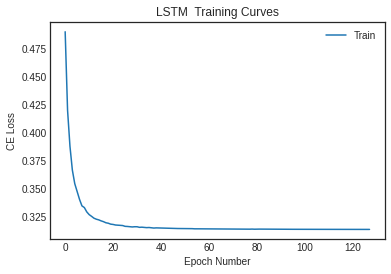

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6178 | test accuracy: 0.512
Epoch:  1 Iteration:  140 | train loss: 0.8597 | test accuracy: 0.481
Epoch:  2 Iteration:  210 | train loss: 0.6949 | test accuracy: 0.478
Epoch:  3 Iteration:  280 | train loss: 0.7550 | test accuracy: 0.502
Epoch:  4 Iteration:  350 | train loss: 0.6471 | test accuracy: 0.465
Epoch:  5 Iteration:  420 | train loss: 0.7064 | test accuracy: 0.495
Epoch:  6 Iteration:  490 | train loss: 0.6876 | test accuracy: 0.522
Epoch:  7 Iteration:  560 | train loss: 0.6818 | test accuracy: 0.498
Epoch:  8 Iteration:  630 | train loss: 0.7517 | test accuracy: 0.475
Epoch:  9 Iteration:  700 | train loss: 0.6932 | test accuracy: 0.515
Epoch:  10 Iteration:  770 | train loss: 0.7529 | test accuracy: 0.502
Epoch:  11 Iteratio

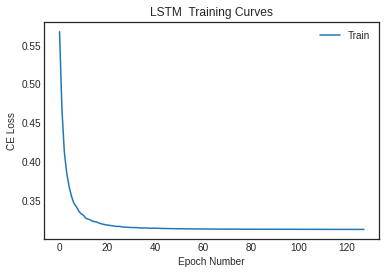

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6381 | test accuracy: 0.468
Epoch:  1 Iteration:  140 | train loss: 0.6526 | test accuracy: 0.508
Epoch:  2 Iteration:  210 | train loss: 0.7407 | test accuracy: 0.458
Epoch:  3 Iteration:  280 | train loss: 0.5336 | test accuracy: 0.522
Epoch:  4 Iteration:  350 | train loss: 0.7258 | test accuracy: 0.471
Epoch:  5 Iteration:  420 | train loss: 0.7193 | test accuracy: 0.502
Epoch:  6 Iteration:  490 | train loss: 0.7717 | test accuracy: 0.475
Epoch:  7 Iteration:  560 | train loss: 0.6678 | test accuracy: 0.505
Epoch:  8 Iteration:  630 | train loss: 0.7106 | test accuracy: 0.519
Epoch:  9 Iteration:  700 | train loss: 0.7757 | test accuracy: 0.478
Epoch:  10 Iteration:  770 | train loss: 0.7010 | test accuracy: 0.519
Epoch:  11 Iteratio

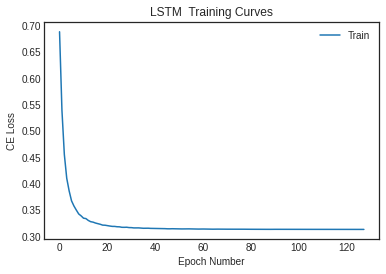

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6686 | test accuracy: 0.512
Epoch:  1 Iteration:  140 | train loss: 0.6681 | test accuracy: 0.495
Epoch:  2 Iteration:  210 | train loss: 0.8682 | test accuracy: 0.485
Epoch:  3 Iteration:  280 | train loss: 0.7143 | test accuracy: 0.498
Epoch:  4 Iteration:  350 | train loss: 0.7106 | test accuracy: 0.488
Epoch:  5 Iteration:  420 | train loss: 0.7384 | test accuracy: 0.508
Epoch:  6 Iteration:  490 | train loss: 0.6720 | test accuracy: 0.505
Epoch:  7 Iteration:  560 | train loss: 0.7905 | test accuracy: 0.525
Epoch:  8 Iteration:  630 | train loss: 0.5805 | test accuracy: 0.495
Epoch:  9 Iteration:  700 | train loss: 0.7175 | test accuracy: 0.498
Epoch:  10 Iteration:  770 | train loss: 0.6711 | test accuracy: 0.512
Epoch:  11 Iteratio

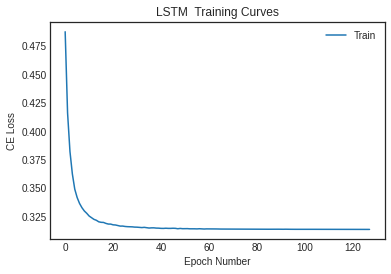

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6742 | test accuracy: 0.481
Epoch:  1 Iteration:  140 | train loss: 0.6825 | test accuracy: 0.515
Epoch:  2 Iteration:  210 | train loss: 0.7285 | test accuracy: 0.488
Epoch:  3 Iteration:  280 | train loss: 0.7323 | test accuracy: 0.508
Epoch:  4 Iteration:  350 | train loss: 0.7751 | test accuracy: 0.515
Epoch:  5 Iteration:  420 | train loss: 0.5090 | test accuracy: 0.515
Epoch:  6 Iteration:  490 | train loss: 0.4889 | test accuracy: 0.515
Epoch:  7 Iteration:  560 | train loss: 0.6945 | test accuracy: 0.522
Epoch:  8 Iteration:  630 | train loss: 0.7719 | test accuracy: 0.485
Epoch:  9 Iteration:  700 | train loss: 0.6397 | test accuracy: 0.515
Epoch:  10 Iteration:  770 | train loss: 0.6642 | test accuracy: 0.505
Epoch:  11 Iteratio

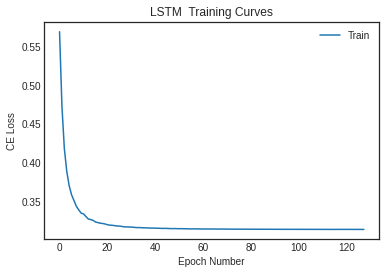

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6857 | test accuracy: 0.458
Epoch:  1 Iteration:  140 | train loss: 0.7428 | test accuracy: 0.529
Epoch:  2 Iteration:  210 | train loss: 0.8897 | test accuracy: 0.515
Epoch:  3 Iteration:  280 | train loss: 0.6718 | test accuracy: 0.522
Epoch:  4 Iteration:  350 | train loss: 0.7286 | test accuracy: 0.515
Epoch:  5 Iteration:  420 | train loss: 0.6819 | test accuracy: 0.522
Epoch:  6 Iteration:  490 | train loss: 0.7325 | test accuracy: 0.525
Epoch:  7 Iteration:  560 | train loss: 0.6457 | test accuracy: 0.515
Epoch:  8 Iteration:  630 | train loss: 0.6988 | test accuracy: 0.481
Epoch:  9 Iteration:  700 | train loss: 0.7250 | test accuracy: 0.519
Epoch:  10 Iteration:  770 | train loss: 0.6283 | test accuracy: 0.515
Epoch:  11 Iteratio

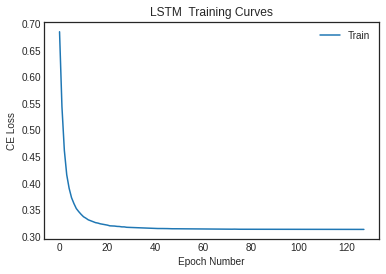

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6775 | test accuracy: 0.475
Epoch:  1 Iteration:  140 | train loss: 0.7086 | test accuracy: 0.519
Epoch:  2 Iteration:  210 | train loss: 0.6541 | test accuracy: 0.535
Epoch:  3 Iteration:  280 | train loss: 0.7490 | test accuracy: 0.485
Epoch:  4 Iteration:  350 | train loss: 0.7495 | test accuracy: 0.465
Epoch:  5 Iteration:  420 | train loss: 0.6853 | test accuracy: 0.512
Epoch:  6 Iteration:  490 | train loss: 0.7047 | test accuracy: 0.502
Epoch:  7 Iteration:  560 | train loss: 0.7267 | test accuracy: 0.515
Epoch:  8 Iteration:  630 | train loss: 0.6511 | test accuracy: 0.532
Epoch:  9 Iteration:  700 | train loss: 0.6904 | test accuracy: 0.488
Epoch:  10 Iteration:  770 | train loss: 0.6633 | test accuracy: 0.508
Epoch:  11 Iteratio

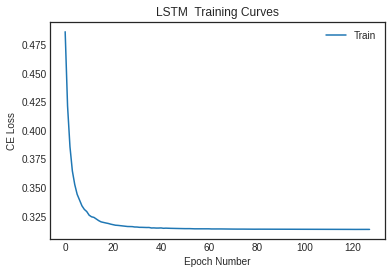

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
n_states = 2
n_features = 3
length = 1000
window_length = 10
train_ratio = 0.7
method = "basic"
flip_probabilities = [0.1, 0.5, 0.9]
rnn_arr2 = []
nrnn_arr2 = []
lstm_arr2 = []
seed_arr2 = []
method_arr2 = []
specify_arr2 = []


for flip_probability in flip_probabilities:

  x_train, y_train_true, y_train_flipped, x_test, y_test_true, y_test_flipped= generate_dataset(n_states, n_features, length,window_length, train_ratio, method, 
                      flip_probability, flip_probability_0=None, flip_probability_1=None,
                      startprob=None, transmat=None)
  
  basic_train_flipped = data_utils.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train_flipped))
  basic_train_flipped_loader = data_utils.DataLoader(basic_train_flipped, batch_size=10, shuffle=True)

  basic_test_flipped = data_utils.TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test_flipped))
  basic_test_flipped_loader = data_utils.DataLoader(basic_test_flipped, batch_size=25, shuffle=True)

  for seed in seeds:
    acc = driver(seed, basic_train_flipped_loader, basic_test_flipped_loader)
    acc2 = driver(seed, basic_train_flipped_loader, basic_test_flipped_loader, nrnn = True)
    acc3 = lstm_driver(seed, x_test, y_test_flipped, x_train, y_train_flipped)
    rnn_arr2.append(acc)
    nrnn_arr2.append(acc2)
    lstm_arr2.append(acc3)
    seed_arr2.append(seed)
    method_arr2.append(method)
    specify_arr2.append(flip_probability)

Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.8367 | test accuracy: 0.650
Epoch:  1 Iteration:  140 | train loss: 0.5784 | test accuracy: 0.650
Epoch:  2 Iteration:  210 | train loss: 0.5370 | test accuracy: 0.684
Epoch:  3 Iteration:  280 | train loss: 0.7865 | test accuracy: 0.704
Epoch:  4 Iteration:  350 | train loss: 0.8003 | test accuracy: 0.646
Epoch:  5 Iteration:  420 | train loss: 0.5912 | test accuracy: 0.677
Epoch:  6 Iteration:  490 | train loss: 0.4034 | test accuracy: 0.650
Epoch:  7 Iteration:  560 | train loss: 0.8002 | test accuracy: 0.677
Epoch:  8 Iteration:  630 | train loss: 1.0755 | test accuracy: 0.700
Epoch:  9 Iteration:  700 | train loss: 0.4709 | test accuracy: 0.694
Epoch:  10 Iteration:  770 | train loss: 0.8795 | test accuracy: 0.700
Epoch:  11 Iteratio

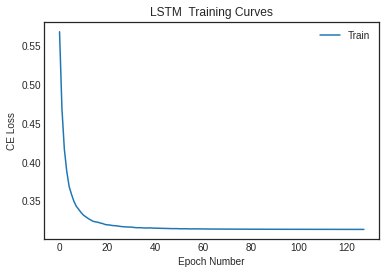

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.3721 | test accuracy: 0.650
Epoch:  1 Iteration:  140 | train loss: 1.0153 | test accuracy: 0.650
Epoch:  2 Iteration:  210 | train loss: 0.4087 | test accuracy: 0.650
Epoch:  3 Iteration:  280 | train loss: 0.7982 | test accuracy: 0.646
Epoch:  4 Iteration:  350 | train loss: 0.5583 | test accuracy: 0.697
Epoch:  5 Iteration:  420 | train loss: 0.6033 | test accuracy: 0.650
Epoch:  6 Iteration:  490 | train loss: 0.3672 | test accuracy: 0.653
Epoch:  7 Iteration:  560 | train loss: 0.7901 | test accuracy: 0.663
Epoch:  8 Iteration:  630 | train loss: 0.4638 | test accuracy: 0.657
Epoch:  9 Iteration:  700 | train loss: 0.5503 | test accuracy: 0.687
Epoch:  10 Iteration:  770 | train loss: 0.4592 | test accuracy: 0.694
Epoch:  11 Iteratio

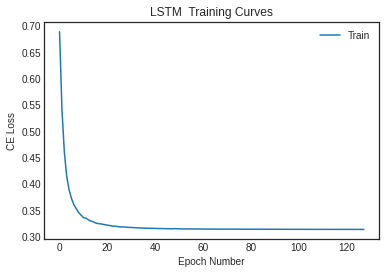

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.5928 | test accuracy: 0.650
Epoch:  1 Iteration:  140 | train loss: 0.9469 | test accuracy: 0.650
Epoch:  2 Iteration:  210 | train loss: 0.4585 | test accuracy: 0.653
Epoch:  3 Iteration:  280 | train loss: 0.5535 | test accuracy: 0.646
Epoch:  4 Iteration:  350 | train loss: 0.6445 | test accuracy: 0.657
Epoch:  5 Iteration:  420 | train loss: 0.5792 | test accuracy: 0.653
Epoch:  6 Iteration:  490 | train loss: 0.4800 | test accuracy: 0.684
Epoch:  7 Iteration:  560 | train loss: 0.5160 | test accuracy: 0.653
Epoch:  8 Iteration:  630 | train loss: 0.5212 | test accuracy: 0.684
Epoch:  9 Iteration:  700 | train loss: 0.6161 | test accuracy: 0.616
Epoch:  10 Iteration:  770 | train loss: 0.8299 | test accuracy: 0.657
Epoch:  11 Iteratio

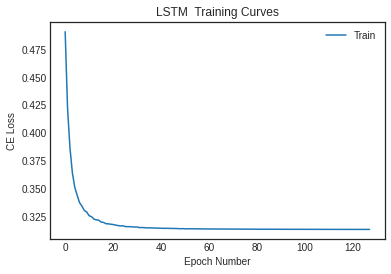

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6706 | test accuracy: 0.805
Epoch:  1 Iteration:  140 | train loss: 0.6861 | test accuracy: 0.805
Epoch:  2 Iteration:  210 | train loss: 0.1964 | test accuracy: 0.805
Epoch:  3 Iteration:  280 | train loss: 0.6664 | test accuracy: 0.805
Epoch:  4 Iteration:  350 | train loss: 0.1579 | test accuracy: 0.805
Epoch:  5 Iteration:  420 | train loss: 0.6935 | test accuracy: 0.805
Epoch:  6 Iteration:  490 | train loss: 0.1383 | test accuracy: 0.805
Epoch:  7 Iteration:  560 | train loss: 0.1876 | test accuracy: 0.805
Epoch:  8 Iteration:  630 | train loss: 0.1654 | test accuracy: 0.805
Epoch:  9 Iteration:  700 | train loss: 0.1372 | test accuracy: 0.805
Epoch:  10 Iteration:  770 | train loss: 0.2103 | test accuracy: 0.805
Epoch:  11 Iteratio

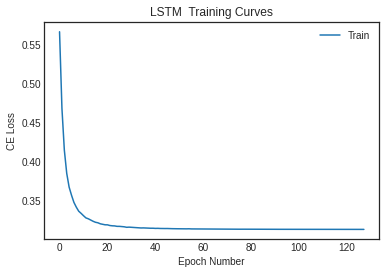

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.2360 | test accuracy: 0.805
Epoch:  1 Iteration:  140 | train loss: 0.2112 | test accuracy: 0.805
Epoch:  2 Iteration:  210 | train loss: 0.1587 | test accuracy: 0.805
Epoch:  3 Iteration:  280 | train loss: 0.2278 | test accuracy: 0.805
Epoch:  4 Iteration:  350 | train loss: 0.7803 | test accuracy: 0.805
Epoch:  5 Iteration:  420 | train loss: 0.1862 | test accuracy: 0.805
Epoch:  6 Iteration:  490 | train loss: 0.1546 | test accuracy: 0.805
Epoch:  7 Iteration:  560 | train loss: 0.1453 | test accuracy: 0.805
Epoch:  8 Iteration:  630 | train loss: 0.2544 | test accuracy: 0.805
Epoch:  9 Iteration:  700 | train loss: 0.6602 | test accuracy: 0.805
Epoch:  10 Iteration:  770 | train loss: 0.1511 | test accuracy: 0.805
Epoch:  11 Iteratio

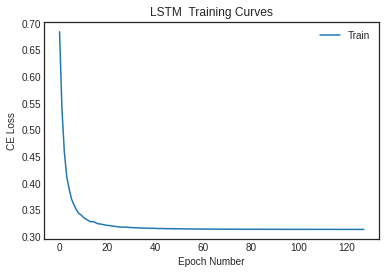

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.7110 | test accuracy: 0.805
Epoch:  1 Iteration:  140 | train loss: 0.7163 | test accuracy: 0.805
Epoch:  2 Iteration:  210 | train loss: 0.2080 | test accuracy: 0.805
Epoch:  3 Iteration:  280 | train loss: 0.1994 | test accuracy: 0.805
Epoch:  4 Iteration:  350 | train loss: 0.6514 | test accuracy: 0.805
Epoch:  5 Iteration:  420 | train loss: 0.7197 | test accuracy: 0.805
Epoch:  6 Iteration:  490 | train loss: 0.7311 | test accuracy: 0.805
Epoch:  7 Iteration:  560 | train loss: 0.2995 | test accuracy: 0.805
Epoch:  8 Iteration:  630 | train loss: 0.1562 | test accuracy: 0.805
Epoch:  9 Iteration:  700 | train loss: 0.2364 | test accuracy: 0.805
Epoch:  10 Iteration:  770 | train loss: 0.6278 | test accuracy: 0.805
Epoch:  11 Iteratio

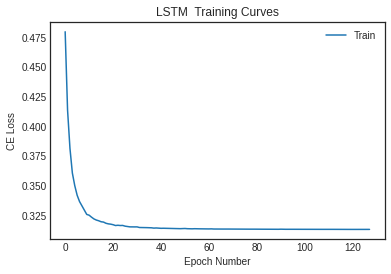

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 1.1522 | test accuracy: 0.822
Epoch:  1 Iteration:  140 | train loss: 0.2203 | test accuracy: 0.822
Epoch:  2 Iteration:  210 | train loss: 1.3377 | test accuracy: 0.822
Epoch:  3 Iteration:  280 | train loss: 0.6634 | test accuracy: 0.822
Epoch:  4 Iteration:  350 | train loss: 1.3559 | test accuracy: 0.822
Epoch:  5 Iteration:  420 | train loss: 0.7354 | test accuracy: 0.822
Epoch:  6 Iteration:  490 | train loss: 0.6344 | test accuracy: 0.822
Epoch:  7 Iteration:  560 | train loss: 0.6804 | test accuracy: 0.822
Epoch:  8 Iteration:  630 | train loss: 0.7270 | test accuracy: 0.822
Epoch:  9 Iteration:  700 | train loss: 0.7194 | test accuracy: 0.822
Epoch:  10 Iteration:  770 | train loss: 0.5529 | test accuracy: 0.822
Epoch:  11 Iteratio

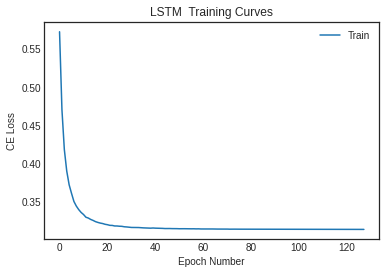

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6689 | test accuracy: 0.822
Epoch:  1 Iteration:  140 | train loss: 0.6677 | test accuracy: 0.822
Epoch:  2 Iteration:  210 | train loss: 0.2177 | test accuracy: 0.822
Epoch:  3 Iteration:  280 | train loss: 0.8316 | test accuracy: 0.822
Epoch:  4 Iteration:  350 | train loss: 0.1921 | test accuracy: 0.822
Epoch:  5 Iteration:  420 | train loss: 0.2045 | test accuracy: 0.822
Epoch:  6 Iteration:  490 | train loss: 1.1234 | test accuracy: 0.822
Epoch:  7 Iteration:  560 | train loss: 1.3180 | test accuracy: 0.822
Epoch:  8 Iteration:  630 | train loss: 0.2324 | test accuracy: 0.822
Epoch:  9 Iteration:  700 | train loss: 0.2239 | test accuracy: 0.822
Epoch:  10 Iteration:  770 | train loss: 0.9950 | test accuracy: 0.822
Epoch:  11 Iteratio

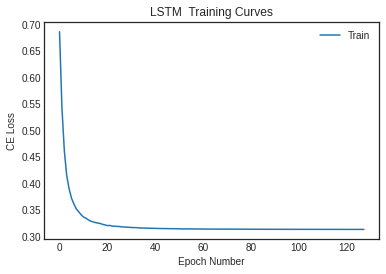

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 1.1455 | test accuracy: 0.822
Epoch:  1 Iteration:  140 | train loss: 0.2174 | test accuracy: 0.822
Epoch:  2 Iteration:  210 | train loss: 0.2476 | test accuracy: 0.822
Epoch:  3 Iteration:  280 | train loss: 0.1944 | test accuracy: 0.822
Epoch:  4 Iteration:  350 | train loss: 0.2262 | test accuracy: 0.822
Epoch:  5 Iteration:  420 | train loss: 0.6432 | test accuracy: 0.822
Epoch:  6 Iteration:  490 | train loss: 0.5874 | test accuracy: 0.822
Epoch:  7 Iteration:  560 | train loss: 0.6947 | test accuracy: 0.822
Epoch:  8 Iteration:  630 | train loss: 1.2931 | test accuracy: 0.822
Epoch:  9 Iteration:  700 | train loss: 0.1982 | test accuracy: 0.822
Epoch:  10 Iteration:  770 | train loss: 0.6556 | test accuracy: 0.822
Epoch:  11 Iteratio

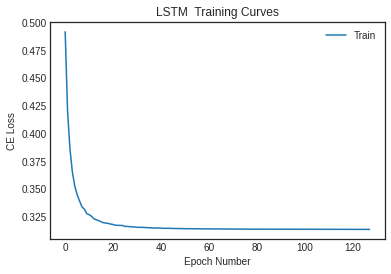

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.4766 | test accuracy: 0.515
Epoch:  1 Iteration:  140 | train loss: 0.7600 | test accuracy: 0.556
Epoch:  2 Iteration:  210 | train loss: 0.8995 | test accuracy: 0.593
Epoch:  3 Iteration:  280 | train loss: 0.6002 | test accuracy: 0.593
Epoch:  4 Iteration:  350 | train loss: 0.9311 | test accuracy: 0.579
Epoch:  5 Iteration:  420 | train loss: 0.4732 | test accuracy: 0.569
Epoch:  6 Iteration:  490 | train loss: 0.7514 | test accuracy: 0.606
Epoch:  7 Iteration:  560 | train loss: 0.3391 | test accuracy: 0.609
Epoch:  8 Iteration:  630 | train loss: 0.4988 | test accuracy: 0.626
Epoch:  9 Iteration:  700 | train loss: 0.4205 | test accuracy: 0.633
Epoch:  10 Iteration:  770 | train loss: 0.8864 | test accuracy: 0.626
Epoch:  11 Iteratio

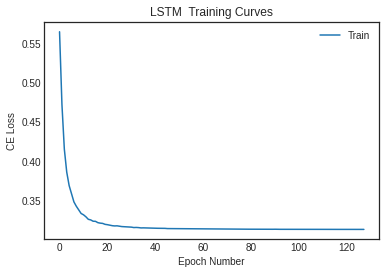

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.7185 | test accuracy: 0.525
Epoch:  1 Iteration:  140 | train loss: 0.6300 | test accuracy: 0.532
Epoch:  2 Iteration:  210 | train loss: 0.7216 | test accuracy: 0.609
Epoch:  3 Iteration:  280 | train loss: 0.6243 | test accuracy: 0.599
Epoch:  4 Iteration:  350 | train loss: 0.7673 | test accuracy: 0.620
Epoch:  5 Iteration:  420 | train loss: 0.7173 | test accuracy: 0.606
Epoch:  6 Iteration:  490 | train loss: 0.6705 | test accuracy: 0.623
Epoch:  7 Iteration:  560 | train loss: 0.7448 | test accuracy: 0.623
Epoch:  8 Iteration:  630 | train loss: 0.4743 | test accuracy: 0.599
Epoch:  9 Iteration:  700 | train loss: 0.7377 | test accuracy: 0.613
Epoch:  10 Iteration:  770 | train loss: 0.5926 | test accuracy: 0.633
Epoch:  11 Iteratio

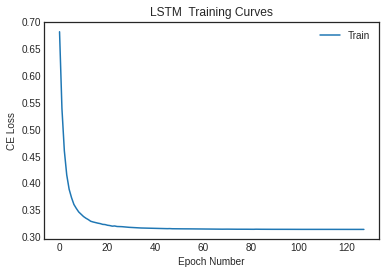

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6392 | test accuracy: 0.525
Epoch:  1 Iteration:  140 | train loss: 0.7746 | test accuracy: 0.582
Epoch:  2 Iteration:  210 | train loss: 0.6337 | test accuracy: 0.613
Epoch:  3 Iteration:  280 | train loss: 0.4991 | test accuracy: 0.626
Epoch:  4 Iteration:  350 | train loss: 0.9303 | test accuracy: 0.589
Epoch:  5 Iteration:  420 | train loss: 0.7216 | test accuracy: 0.616
Epoch:  6 Iteration:  490 | train loss: 0.4966 | test accuracy: 0.586
Epoch:  7 Iteration:  560 | train loss: 0.4277 | test accuracy: 0.616
Epoch:  8 Iteration:  630 | train loss: 0.6147 | test accuracy: 0.613
Epoch:  9 Iteration:  700 | train loss: 0.5344 | test accuracy: 0.623
Epoch:  10 Iteration:  770 | train loss: 0.9910 | test accuracy: 0.613
Epoch:  11 Iteratio

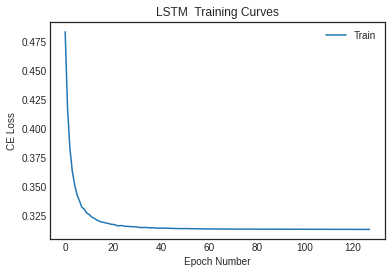

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
n_states = 2
n_features = 3
length = 1000
window_length = 10
train_ratio = 0.7
method = "class"
rnn_arr3 = []
nrnn_arr3 = []
lstm_arr3 = []
seed_arr3 = []
method_arr3 = []
specify_arr3 = []

flip_probabilities_0 = [0.2, 0.8]
flip_probabilities_1 = [0.2, 0.8]

for flip_probability_0 in flip_probabilities_0:
  for flip_probability_1 in flip_probabilities_1:

    x_train, y_train_true, y_train_flipped, x_test, y_test_true, y_test_flipped = generate_dataset(n_states, n_features, length,window_length, train_ratio, method, 
                        flip_probability= None, flip_probability_0=flip_probability_0, flip_probability_1 = flip_probability_1,
                        startprob=None, transmat=None)

    class_train_flipped = data_utils.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train_flipped))
    class_train_flipped_loader = data_utils.DataLoader(class_train_flipped, batch_size=10, shuffle=True)

    class_test_flipped = data_utils.TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test_flipped))
    class_test_flipped_loader = data_utils.DataLoader(class_test_flipped, batch_size=25, shuffle=True)

    for seed in seeds:
      acc = driver(seed, class_train_flipped_loader, class_test_flipped_loader)
      acc2 = driver(seed, class_train_flipped_loader, class_test_flipped_loader, nrnn = True)
      acc3 = lstm_driver(seed, x_test, y_test_flipped, x_train, y_train_flipped)
      rnn_arr3.append(acc)
      nrnn_arr3.append(acc2)
      lstm_arr3.append(acc3)
      seed_arr3.append(seed)
      method_arr3.append(method)
      specify_arr3.append((flip_probability_0, flip_probability_1))

Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6284 | test accuracy: 0.630
Epoch:  1 Iteration:  140 | train loss: 0.6199 | test accuracy: 0.673
Epoch:  2 Iteration:  210 | train loss: 0.7834 | test accuracy: 0.737
Epoch:  3 Iteration:  280 | train loss: 0.7623 | test accuracy: 0.724
Epoch:  4 Iteration:  350 | train loss: 0.6691 | test accuracy: 0.771
Epoch:  5 Iteration:  420 | train loss: 0.2774 | test accuracy: 0.815
Epoch:  6 Iteration:  490 | train loss: 0.7189 | test accuracy: 0.828
Epoch:  7 Iteration:  560 | train loss: 0.5047 | test accuracy: 0.953
Epoch:  8 Iteration:  630 | train loss: 0.3402 | test accuracy: 0.990
Epoch:  9 Iteration:  700 | train loss: 0.1091 | test accuracy: 0.993
Epoch:  10 Iteration:  770 | train loss: 0.1288 | test accuracy: 1.000
Epoch:  11 Iteratio

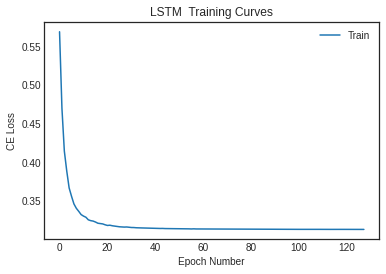

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.7059 | test accuracy: 0.566
Epoch:  1 Iteration:  140 | train loss: 0.6246 | test accuracy: 0.707
Epoch:  2 Iteration:  210 | train loss: 0.7665 | test accuracy: 0.734
Epoch:  3 Iteration:  280 | train loss: 0.3959 | test accuracy: 0.700
Epoch:  4 Iteration:  350 | train loss: 0.5860 | test accuracy: 0.764
Epoch:  5 Iteration:  420 | train loss: 0.4213 | test accuracy: 0.771
Epoch:  6 Iteration:  490 | train loss: 0.4140 | test accuracy: 0.828
Epoch:  7 Iteration:  560 | train loss: 0.5255 | test accuracy: 0.906
Epoch:  8 Iteration:  630 | train loss: 0.3613 | test accuracy: 0.963
Epoch:  9 Iteration:  700 | train loss: 0.1504 | test accuracy: 0.966
Epoch:  10 Iteration:  770 | train loss: 0.1718 | test accuracy: 0.997
Epoch:  11 Iteratio

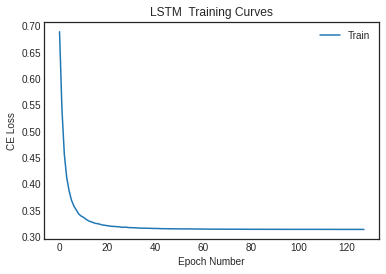

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6229 | test accuracy: 0.663
Epoch:  1 Iteration:  140 | train loss: 0.7941 | test accuracy: 0.680
Epoch:  2 Iteration:  210 | train loss: 0.5564 | test accuracy: 0.650
Epoch:  3 Iteration:  280 | train loss: 0.3675 | test accuracy: 0.761
Epoch:  4 Iteration:  350 | train loss: 0.3785 | test accuracy: 0.744
Epoch:  5 Iteration:  420 | train loss: 0.5334 | test accuracy: 0.805
Epoch:  6 Iteration:  490 | train loss: 0.2765 | test accuracy: 0.761
Epoch:  7 Iteration:  560 | train loss: 0.5237 | test accuracy: 0.892
Epoch:  8 Iteration:  630 | train loss: 0.2138 | test accuracy: 0.896
Epoch:  9 Iteration:  700 | train loss: 0.4954 | test accuracy: 0.929
Epoch:  10 Iteration:  770 | train loss: 0.2272 | test accuracy: 0.976
Epoch:  11 Iteratio

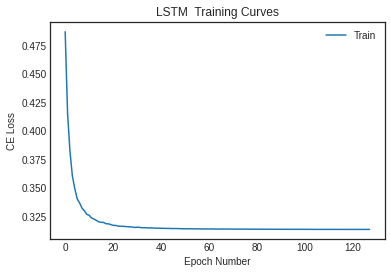

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.4171 | test accuracy: 0.690
Epoch:  1 Iteration:  140 | train loss: 0.4253 | test accuracy: 0.721
Epoch:  2 Iteration:  210 | train loss: 0.6421 | test accuracy: 0.758
Epoch:  3 Iteration:  280 | train loss: 0.5363 | test accuracy: 0.778
Epoch:  4 Iteration:  350 | train loss: 0.9399 | test accuracy: 0.778
Epoch:  5 Iteration:  420 | train loss: 0.4638 | test accuracy: 0.791
Epoch:  6 Iteration:  490 | train loss: 0.8380 | test accuracy: 0.818
Epoch:  7 Iteration:  560 | train loss: 1.2180 | test accuracy: 0.832
Epoch:  8 Iteration:  630 | train loss: 0.7112 | test accuracy: 0.845
Epoch:  9 Iteration:  700 | train loss: 0.4699 | test accuracy: 0.845
Epoch:  10 Iteration:  770 | train loss: 0.2071 | test accuracy: 0.872
Epoch:  11 Iteratio

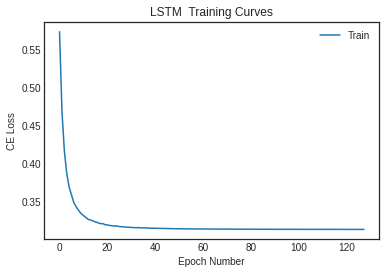

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.4441 | test accuracy: 0.687
Epoch:  1 Iteration:  140 | train loss: 0.3854 | test accuracy: 0.697
Epoch:  2 Iteration:  210 | train loss: 0.9558 | test accuracy: 0.721
Epoch:  3 Iteration:  280 | train loss: 0.3927 | test accuracy: 0.761
Epoch:  4 Iteration:  350 | train loss: 0.1966 | test accuracy: 0.774
Epoch:  5 Iteration:  420 | train loss: 0.1437 | test accuracy: 0.791
Epoch:  6 Iteration:  490 | train loss: 0.3020 | test accuracy: 0.825
Epoch:  7 Iteration:  560 | train loss: 0.8377 | test accuracy: 0.848
Epoch:  8 Iteration:  630 | train loss: 0.0616 | test accuracy: 0.845
Epoch:  9 Iteration:  700 | train loss: 0.0845 | test accuracy: 0.882
Epoch:  10 Iteration:  770 | train loss: 0.2547 | test accuracy: 0.919
Epoch:  11 Iteratio

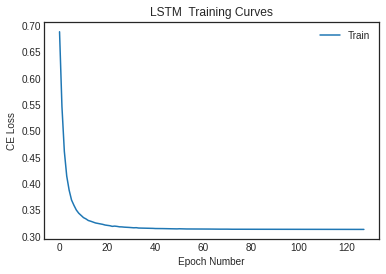

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.5024 | test accuracy: 0.707
Epoch:  1 Iteration:  140 | train loss: 0.4479 | test accuracy: 0.704
Epoch:  2 Iteration:  210 | train loss: 0.1697 | test accuracy: 0.744
Epoch:  3 Iteration:  280 | train loss: 0.4900 | test accuracy: 0.771
Epoch:  4 Iteration:  350 | train loss: 0.5317 | test accuracy: 0.785
Epoch:  5 Iteration:  420 | train loss: 0.2955 | test accuracy: 0.788
Epoch:  6 Iteration:  490 | train loss: 0.3372 | test accuracy: 0.825
Epoch:  7 Iteration:  560 | train loss: 0.2465 | test accuracy: 0.859
Epoch:  8 Iteration:  630 | train loss: 0.3176 | test accuracy: 0.875
Epoch:  9 Iteration:  700 | train loss: 0.6338 | test accuracy: 0.889
Epoch:  10 Iteration:  770 | train loss: 0.4020 | test accuracy: 0.929
Epoch:  11 Iteratio

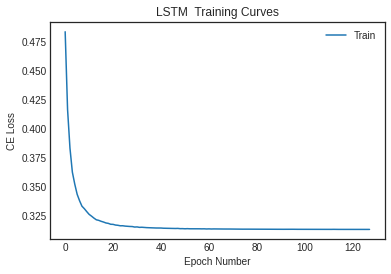

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.6716 | test accuracy: 0.690
Epoch:  1 Iteration:  140 | train loss: 0.4011 | test accuracy: 0.754
Epoch:  2 Iteration:  210 | train loss: 0.5040 | test accuracy: 0.751
Epoch:  3 Iteration:  280 | train loss: 0.7318 | test accuracy: 0.764
Epoch:  4 Iteration:  350 | train loss: 0.2679 | test accuracy: 0.778
Epoch:  5 Iteration:  420 | train loss: 0.2612 | test accuracy: 0.811
Epoch:  6 Iteration:  490 | train loss: 0.4427 | test accuracy: 0.818
Epoch:  7 Iteration:  560 | train loss: 0.5244 | test accuracy: 0.859
Epoch:  8 Iteration:  630 | train loss: 0.2551 | test accuracy: 0.869
Epoch:  9 Iteration:  700 | train loss: 0.2372 | test accuracy: 0.886
Epoch:  10 Iteration:  770 | train loss: 0.6480 | test accuracy: 0.902
Epoch:  11 Iteratio

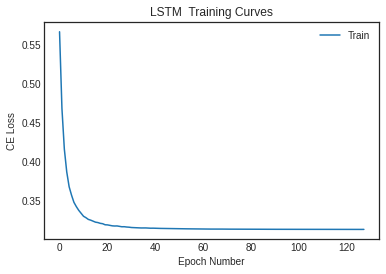

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.5136 | test accuracy: 0.724
Epoch:  1 Iteration:  140 | train loss: 0.5486 | test accuracy: 0.764
Epoch:  2 Iteration:  210 | train loss: 0.4434 | test accuracy: 0.761
Epoch:  3 Iteration:  280 | train loss: 0.8252 | test accuracy: 0.768
Epoch:  4 Iteration:  350 | train loss: 0.3380 | test accuracy: 0.758
Epoch:  5 Iteration:  420 | train loss: 0.1020 | test accuracy: 0.805
Epoch:  6 Iteration:  490 | train loss: 0.4275 | test accuracy: 0.811
Epoch:  7 Iteration:  560 | train loss: 0.4835 | test accuracy: 0.838
Epoch:  8 Iteration:  630 | train loss: 0.0794 | test accuracy: 0.845
Epoch:  9 Iteration:  700 | train loss: 0.1980 | test accuracy: 0.859
Epoch:  10 Iteration:  770 | train loss: 0.2958 | test accuracy: 0.886
Epoch:  11 Iteratio

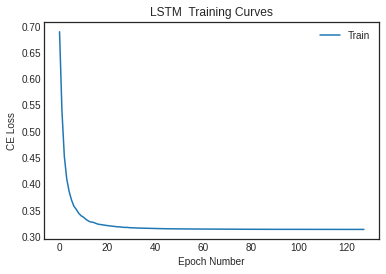

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Connected to a GPU
NoisyRNN(
  (tanh): Tanh()
  (E): Linear(in_features=3, out_features=64, bias=True)
  (D): Linear(in_features=64, out_features=2, bias=True)
)
**** Setup ****
Total params: 8.64k
************
Epoch:  0 Iteration:  70 | train loss: 0.9163 | test accuracy: 0.721
Epoch:  1 Iteration:  140 | train loss: 0.3263 | test accuracy: 0.751
Epoch:  2 Iteration:  210 | train loss: 0.4424 | test accuracy: 0.754
Epoch:  3 Iteration:  280 | train loss: 0.8890 | test accuracy: 0.761
Epoch:  4 Iteration:  350 | train loss: 0.3769 | test accuracy: 0.791
Epoch:  5 Iteration:  420 | train loss: 0.3092 | test accuracy: 0.781
Epoch:  6 Iteration:  490 | train loss: 0.6500 | test accuracy: 0.781
Epoch:  7 Iteration:  560 | train loss: 0.5734 | test accuracy: 0.818
Epoch:  8 Iteration:  630 | train loss: 0.8525 | test accuracy: 0.838
Epoch:  9 Iteration:  700 | train loss: 0.4535 | test accuracy: 0.859
Epoch:  10 Iteration:  770 | train loss: 0.2556 | test accuracy: 0.859
Epoch:  11 Iteratio

In [ ]:
n_states = 2
n_features = 3
length = 1000
window_length = 10
train_ratio = 0.7
method = "time"
rnn_arr4 = []
nrnn_arr4 = []
lstm_arr4 = []
seed_arr4 = []
method_arr4 = []
specify_arr4 = []

startprob = random_startprob(2)
transmat1 = np.array([[0.95, 0.05],
                    [0.95, 0.05]])

transmat2 = np.array([[0.05, 0.95],
                     [0.05, 0.95]])

transmat3 = np.array([[0.95, 0.05],
                     [0.05, 0.95]])

transmats = [transmat1, transmat2, transmat3]
names = ["transmat1", "transmat2", "transmat3"]

for idx, transmat in enumerate(transmats):
  x_train, y_train_true, y_train_flipped, x_test, y_test_true, y_test_flipped = generate_dataset(n_states, n_features,length, window_length, train_ratio, method, 
                      flip_probability=None, flip_probability_0=None, flip_probability_1=None,
                      startprob=startprob, transmat=transmat1)

  time_train_flipped = data_utils.TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train_flipped))
  time_train_flipped_loader = data_utils.DataLoader(time_train_flipped, batch_size=10, shuffle=True)

  time_test_flipped = data_utils.TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test_flipped))
  time_test_flipped_loader = data_utils.DataLoader(time_test_flipped, batch_size=25, shuffle=True)

  for seed in seeds:
      acc = driver(seed, time_train_flipped_loader, time_test_flipped_loader)
      acc2 = driver(seed, time_train_flipped_loader, time_test_flipped_loader, nrnn = True)
      acc3 = lstm_driver(seed, x_test, y_test_flipped, x_train, y_train_flipped)
      rnn_arr4.append(acc)
      nrnn_arr4.append(acc2)
      lstm_arr4.append(acc3)
      seed_arr4.append(seed)
      method_arr4.append(method)
      specify_arr4.append(names[idx])

In [ ]:
import pandas as pd
rnn_arr = rnn_arr1 + rnn_arr2 + rnn_arr3 + rnn_arr4
nrnn_arr = nrnn_arr1 + nrnn_arr2 + nrnn_arr3 + nrnn_arr4
seed_arr = seed_arr1 + seed_arr2 + seed_arr3 + seed_arr4
method_arr = method_arr1 + method_arr2 + method_arr3 + method_arr4
specify_arr = specify_arr1 + specify_arr2 + specify_arr3 + specify_arr4

df1 = pd.DataFrame(list(zip(rnn_arr, nrnn_arr, seed_arr, method_arr, specify_arr)), columns = ["RNN Accuracy", "NRNN Accuracy", "Seed", "Method", "Specify"])
df1
df1.to_csv('out.csv')  

In [ ]:
import pandas as pd

df1 = pd.DataFrame(list(zip(rnn_arr1, nrnn_arr1, lstm_arr1, seed_arr1, method_arr1, specify_arr1)))
df1